<a href="https://colab.research.google.com/github/nverchev/VAEX/blob/main/VAEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAEX
This notebook shows how to train VAEX to reproduce the results pubblished in the paper Hierarchical variational autoencoders for visual counterfactuals.

In [ ]:
#@title Libraries
#%load_ext autoreload
#%autoreload 2
import zipfile
from glob2 import glob
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import json
import re
import time
import torchvision
from torch import optim
from torch.distributions.normal import Normal
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from skimage import io
from abc import ABCMeta,abstractmethod
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader

In [ ]:
#@title Hyperparameters: { display-mode: "form" }
batch_size = 32 #@param {type: "number"}
x_dim= 129 #@param {type: "number"}
initial_learning_rate = 0.001 #@param {type: "number"}
weight_decay = 0.00000 #@param {type: "number"}
n_resolutions = 5 #@param {type: "number"}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title Download

Download = True #@param {type:"boolean"}
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

if Download:
  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  ids={
  '0B7EVK8r0v71pZjFTYXZWM3FlRnM':'images.zip',
  '0B7EVK8r0v71pblRyaVFSWGxPY0U':'attributes.txt',
  '0B7EVK8r0v71pY0NSMzRuSXJEVkk':'partition.txt'}

  for id, name in ids.items():
    downloaded = drive.CreateFile({'id':id})
    downloaded.GetContentFile(name)
  with zipfile.ZipFile('images.zip', 'r') as zip_ref:
      zip_ref.extractall('./')

In [ ]:
#@title Creating the dataset 
class CelebaDataset(Dataset):

    def __init__(self, data, transform=None, target_attr = 'Male'):
      self.data = data
      self.target_attr = target_attr
      self.transform = transform
    def __getitem__(self, idx):
      id = int(self.data['image_id'][idx])
      img_file = 'img_align_celeba/{:06d}.jpg'.format(id)
      img=io.imread(img_file)
      if self.transform:
        img=self.transform(img)
      attr = self.data[self.target_attr][idx]
      return [img,torch.as_tensor((attr+1)//2,dtype=torch.long)]
    def __len__(self):
      return len(self.data)
  

class CelebaLoader():

    train_val_split=162770
    val_test_split=182637

    def __init__(self, dataset_class=CelebaDataset, **dataset_args):
      self.attributes = self.read_attributes()
      self.dataset_class = dataset_class
      self.dataset_args = dataset_args

    def read_attributes(self):
      with open('attributes.txt', 'r') as reader:
          attributes = reader.read()
      list_attributes = attributes.split('\n')
      attributes_names = ['image_id']+list_attributes[1].split(' ')[:-1]
      numpy_attributes = np.empty((202599,41))
      for line, row in zip(list_attributes[2:],numpy_attributes):
        i = 0
        for attr in line.split(' '):
          if not attr: 
            continue #removes empty strings
          if i == 0:
            attr = attr[:6] # extracting id
          row[i] = int(attr)
          i += 1
      return pd.DataFrame(data=numpy_attributes,columns=attributes_names)

  
    def get_dataset(self,subset):
      if subset == 'train':
        subset_data=self.attributes[:self.train_val_split].reset_index()
      elif subset == 'val':
        subset_data=self.attributes[self.train_val_split:self.val_test_split].reset_index()
      elif subset == 'trainval':
        subset_data=self.attributes[:self.val_test_split].reset_index()
      elif subset == 'test':
        subset_data=self.attributes[self.val_test_split:].reset_index()
      else:
        raise ValueError('Invalid subset name.')
      return self.dataset_class(subset_data,**self.dataset_args)


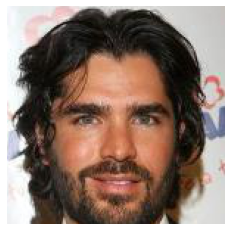

In [ ]:
visualize_sample=162772 #@param {type: "number"}
img=io.imread('img_align_celeba/{:06d}.jpg'.format(visualize_sample))
img=img[35:-35]
img=img[:,15:-15]

plt.imshow(img)
plt.axis('off') 
plt.show()

In [ ]:
#@title Loading & Splitting
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.CenterCrop(148),
                                transforms.Resize(x_dim, interpolation=3),
                                transforms.ToTensor()])


loader = CelebaLoader(transform=transform)
# Creating datasets:
train_dset = loader.get_dataset('train')
val_dset = loader.get_dataset('val')
#trainval_dset = loader.get_dataset('trainval')
test_dset = loader.get_dataset('test')

# Creating data loaders:
train_loader = torch.utils.data.DataLoader(dataset=train_dset,batch_size=batch_size,shuffle=True,drop_last=True)            
val_loader = torch.utils.data.DataLoader(dataset=val_dset,batch_size=batch_size,drop_last=True)            
#trainval_loader = torch.utils.data.DataLoader(dataset=trainval_dset,batch_size=batch_size,shuffle=True,drop_last=True)            
test_loader = torch.utils.data.DataLoader(dataset=test_dset,batch_size=batch_size,drop_last=False)            
loader.attributes

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,-1,1,1,-1,1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1,-1,-1,1


In [ ]:
#@title Block Args
block_args={
    'optim':optim.Adam,
    'initial_lr': initial_learning_rate,
    'weight_decay':weight_decay,
    'train_loader':train_loader,
    'device':device,
    'val_loader': val_loader,
    'test_loader': test_loader,
    'batch_size': batch_size
    }
for k,v in block_args.items():
  if not isinstance(v,(type,torch.utils.data.dataloader.DataLoader)):
    print(k, ': ', v)

initial_lr :  0.001
weight_decay :  0.0
device :  cuda:0
batch_size :  64


In [ ]:
#@title Trainer
class Trainer(metaclass=ABCMeta):
    losses=['final_loss']
    bin='celeba'
    data_path = data_path ## where the network is saved
    def __init__(self,model,version,device,optim,train_loader,val_loader=None,test_loader=None,**block_args):
        self.model = model.to(device)
        self.version = version
        self.settings = {**model.settings,**block_args,'Optimizer':str(optim)}
        self.optimizer = optim(model.parameters(), lr=block_args['initial_lr'], weight_decay=block_args['weight_decay'])
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.train_losses = {loss:[] for loss in self.losses}
        self.val_losses = {loss:[] for loss in self.losses}
        self.test_losses = {loss:[] for loss in self.losses}
        self.test_inputs,self.test_targets,self.test_outputs = [], [], {}
        self.epoch = 0
        self.converge = 1

    def train(self,num_epoch):
        print('Version ',self.version)
        for _ in range(num_epoch):
            self.epoch+=1
            print('====> Epoch:{}'.format(self.epoch))        
            self._run_session(mode='train')
            if self.val_loader:
              self._run_session(mode='val')
        return

    def test(self, on = 'test' , max_outputs = np.inf ):
        print('Version ',self.version)
        self.test_inputs,self.test_targets,self.test_outputs=self._run_session(mode=on,save_outputs=True,max_output=max_outputs) #stored in RAM
        return

    def _run_session(self,mode=train, save_outputs=False , max_output = np.inf):
        time_batch = 0
        time_model = 0
        time_loss = 0
        time_backprop = 0
        if mode == 'train':
            self.model.train()
            torch.set_grad_enabled(True)
            loader=self.train_loader
            dict_losses= self.train_losses           
        elif mode == 'val':
            self.model.eval()
            torch.set_grad_enabled(False)
            loader = self.val_loader
            dict_losses= self.val_losses
        elif mode == 'test':
            self.model.eval()
            torch.set_grad_enabled(False)
            loader = self.test_loader
            dict_losses = self.test_losses
        else:
            raise ValueError('mode options are "train", "val", "test" ')
        if save_outputs:
          test_inputs,test_targets,test_outputs= [], [], {}

        len_sess = len(loader.dataset)
        epoch_loss= {loss:0 for loss in  self.losses}
        iterable=tqdm(enumerate(loader),total=len(loader))
        start = time.time()
        for batch_idx, (inputs, targets) in iterable:
            if self.converge == 0:
              return 
            inputs, targets = self.to_recursive([inputs,targets],device)
            end = time.time()
            aux = self.auxiliary_inputs(inputs,targets)
            time_batch+=end-start          
            start = time.time()
            outputs =  self.model(inputs,**aux)
            end=time.time()
            time_model = end-start
            batch_loss = self.loss(outputs, inputs, targets)
            start = time.time()
            for loss in self.losses:
               epoch_loss[loss]+=batch_loss[loss].item()
            end = time.time()
            time_loss += end-start
            start = time.time()
            if  mode == 'train':
              lss = batch_loss['final_loss']
              if torch.isinf(lss) or torch.isnan(lss):
                self.converge=0
              lss.backward()
              self.optimizer.step()
              self.optimizer.zero_grad()
            if save_outputs and max_output > (batch_idx+1)*loader.batch_size:
              self.extend_dict_list(test_outputs, self.to_recursive(outputs,'detach_cpu'))
              test_inputs.extend(self.to_recursive(inputs,'detach_cpu'))
              test_targets.extend(self.to_recursive(targets,'detach_cpu'))
            if batch_idx % (len(loader)//10) == 0 and mode=='train':
                iterable.set_description('Train [{:4d}/{:4d} ]\tLoss {:4f}'.format(
                     batch_idx * loader.batch_size, len_sess,batch_loss['final_loss'].item()))
            if batch_idx == len(loader)-1 and mode=='train':
                iterable.set_description('') 
            end=time.time()
            time_backprop += end-start
            start = time.time()

        end = time.time()
        #print('batch, model, loss time, back prop time, recon_time, L1 time, kld time:',time_batch,time_model,time_loss,time_backprop)
        num_batch = batch_idx+1
        for loss in self.losses:
            dict_losses[loss].append(epoch_loss[loss]/ num_batch)
        print('Average {} losses :'.format(mode))
        for loss in self.losses:
            print('{}: {:.4f}'.format(loss,dict_losses[loss][-1]), end='\t')
        print()
        if save_outputs:
          return  test_inputs,test_targets,test_outputs
        else:
          return
        
    def auxiliary_inputs(self,inputs,labels):
        return {}

    def update_learning_rate(self,new_lr):
        for g in self.optimizer.param_groups:
            g['lr'] = new_lr

    def load(self, epoch=None):
        directory=self.version
        if epoch:
          self.epoch = epoch
        else:
          past_epochs = []
          for file in minioClient.list_objects(self.bin,recursive=True):
              file_dir, *file_name = file.object_name.split("/")
              if file_dir == directory and file_name[0][:5]=='model':
                past_epochs.append(int(re.sub("\D", "",file_name[0])))
          if len(past_epochs) == 0:
            print("No saved models!")
            return
          max_epoch = max(past_epochs)
          self.epoch = max_epoch
        paths = self.paths()
        for file in paths.values():
            minioClient.fget_object(self.bin,file,os.path.join(self.data_path,file))
        self.model.load_state_dict(torch.load(os.path.join(self.data_path,paths['model']),map_location=torch.device(self.device)))        
        self.optimizer.load_state_dict(torch.load(os.path.join(self.data_path,paths['optim']),map_location=torch.device(self.device)))
        self.train_losses = json.load(open(os.path.join(self.data_path,paths['train_hist'])))
        self.val_losses = json.load(open(os.path.join(self.data_path,paths['val_hist'])))

        print("Loaded: ",paths['model'])
        return

    def save(self,new_version=None):
        self.model.eval()
        paths=self.paths(new_version)
        torch.save(self.model.state_dict(),os.path.join(self.data_path,paths['model']))
        torch.save(self.optimizer.state_dict(),os.path.join(self.data_path,paths['optim']))
        json.dump(self.train_losses, open(os.path.join(self.data_path,paths['train_hist']), 'w'))
        json.dump(self.val_losses, open(os.path.join(self.data_path,paths['val_hist']), 'w'))
        json.dump(self.settings, open(os.path.join(self.data_path,paths['settings']), 'w')) #normally it should be always the same        
        for file in paths.values():
          minioClient.fput_object(self.bin,file,os.path.join(self.data_path,file))
        return
 
    def paths(self,new_version=None):
        if new_version:
          directory = new_version
        else:
          directory = self.version 
        id = self.epoch
        try:
            os.mkdir(os.path.join(self.data_path,directory))
        except:
            pass
        paths = {}
        paths['model'] = "{}/model_epoch{}.pt".format(directory,id)
        paths['optim'] = "{}/optimizer_epoch{}.pt".format(directory,id)
        paths['train_hist'] = "{}/train_losses.json".format(directory)
        paths['val_hist'] = "{}/val_losses.json".format(directory)
        paths['settings'] = "{}/settings.json".format(directory)
        return paths

    def plot_losses(self):
        epochs=np.arange(self.epoch)
        plt.plot(epochs, self.train_losses['final_loss'])
        if self.val_loader:
          plt.plot(epochs, self.val_losses['final_loss'])
        return

    @staticmethod
    def to_recursive(obj, device): #changes device in dictionary and lists of tensors
      if isinstance(obj, list):
        obj = [Trainer.to_recursive(item, device) for item in obj]
      elif isinstance(obj, dict):
        obj = {k: Trainer.to_recursive(v, device) for k,v in obj.items()}
      else:
        try: 
          obj=obj.detach().cpu() if device == 'detach_cpu' else  obj.to(device)
        except AttributeError:
          raise ValueError('Datatype {} do not contain tensors'.format(type(obj)))
      return obj

    @staticmethod #extends lists in dictionaries
    def extend_dict_list(old_dict, new_dict):
      for key,value in new_dict.items():         
          if key not in old_dict.keys():
            old_dict[key]=[]
            if isinstance(value,list):
              for elem in value:
                old_dict[key].append([])
          if isinstance(value,list):
            for elem, new_elem in zip( old_dict[key],value):
              elem.extend(new_elem)
          else: 
            old_dict[key].extend(value)
    
    @staticmethod #indexes a list (inside of a list) inside of a dictionary
    def index_dict_list(dict_list,ind):
      list_dict = {}
      for k, v in dict_list.items():
        if len(v) == 0 or isinstance(v[0],list):
          new_v = []
          for elem in v:
            new_v.append(elem[ind].unsqueeze(0))
        else:
          new_v = v[ind].unsqueeze(0)
        list_dict[k] = new_v
      return list_dict

    @abstractmethod
    def loss(self,output, inputs, targets):
        pass


In [ ]:
#@title Losses and Visualization

class CELoss():
    losses=['final_loss','CE loss']
    def loss(self, outputs, img, targets):
      CE=F.cross_entropy(outputs['probs'], targets)
      return {'final_loss':CE,
              'CE loss':CE}

class DiscriminatorLoss():
    losses=['final_loss','True loss','Fake loss']
    def loss(self, outputs, img, targets):
      true, fake = outputs['wasserstein'].chunk(2,0)
      true_loss = true.mean()
      fake_loss = -fake.mean()
      return {'final_loss':true_loss+fake_loss,
              'True loss':true_loss,
              'Fake loss':fake_loss}


class VAELoss():
    losses=['final_loss','real_loss','NLL','MSE','KLD','ADV']    
    num_classes = 2
    dim_top_channel = (2**(6 - n_resolutions) + 1)**2 #spatial dimension top latent variable
    c_KLD = 100
    train_var = None #calculated variance
    train_logvar = None #calculated logvariance
    adj_nll = 0.5*np.log(2*np.pi) #adjustment to calculate the NLL
    scale_prior = 5
    def loss(self, outputs,inputs,targets):
        KLD,KLD_real = self.kld_loss(inputs, outputs, targets)
        NLL,MSE = self.nll_loss(inputs, outputs['recon'])
        ADV = self.adversarial_loss(inputs,outputs['recon'])
        return {'final_loss': NLL + self.c_KLD*KLD + ADV,
                'real_loss':NLL + KLD_real,
                'KLD': KLD_real,
                'NLL': NLL,
                'MSE' : MSE,
                'ADV': ADV,
                }

    def nll_loss(self, inputs, recon):
         SE = F.mse_loss(recon, inputs, reduction='none')
         if self.train_var is None:
           self.train_var = SE.mean(0).detach()
           self.train_logvar = torch.log(self.train_var)
         local_device = recon.device #makes sure you can change device during training
         train_var, train_logvar = self.train_var.to(local_device), self.train_logvar.to(local_device)
         NLL = 0.5*(SE/train_var + train_logvar).mean(0).sum() + self.adj_nll*train_var.numel()
         if self.model.training:
           self.train_var = 0.9*train_var+0.1*SE.mean(0).detach()
           self.train_logvar = torch.log(self.train_var)
         return NLL, SE.mean()
    
    def kld_loss(self,inputs,outputs,targets,freebits=1):
          prior_mu = self.condition(inputs,outputs,targets)
          q_mu = outputs['mu'][0]
          q_logvar = outputs['log_var'][0]
          KLD_matrix = -1 - q_logvar + (q_mu-prior_mu)**2 + q_logvar.exp()
          KLD_free_bits = F.softplus(KLD_matrix-2*freebits)+2*freebits
          KLD = 0.5 * KLD_free_bits.mean(0).sum()
          KLD_real = 0.5 * KLD_matrix.mean(0).sum()
          for d_mu, d_logvar, p_logvar in zip(outputs['mu'][1:],outputs['log_var'][1:],outputs['prior_log_var']):
                #d_mu = q_mu - p_mu
                #d_logvar = q_logvar - p_logvar  
                KLD_matrix = -1-d_logvar + d_logvar.exp() + (d_mu**2)/p_logvar.exp()
                KLD_free_bits = F.softplus(KLD_matrix-2*freebits)+2*freebits
                KLD += 0.5*KLD_free_bits.mean(0).sum()
                KLD_real += 0.5*KLD_matrix.mean(0).sum()
          return KLD,KLD_real

    def condition(self,inputs,outputs,targets):
          return torch.zeros_like(outputs['mu'][0])

    def adversarial_loss(self,inputs,recon):
          return torch.zeros(1).to(self.device)
        
        
class CVAELossPrior(VAELoss):
    # prior condition on targets
    def condition(self,inputs,outputs,targets):      
      conditional = torch.zeros_like(outputs['mu'][0])
      for t, target in enumerate(targets):
        if target != self.num_classes - 1:
          conditional[t,target*self.dim_top_channel:(target+1)*self.dim_top_channel] = self.scale_prior
      return conditional


class VAELossPrior(VAELoss):
    #prior condition on probablities (calculated for simplicity, can be stored)
    def condition(self,inputs,outputs,targets):
      f = lambda x: (torch.sqrt(x)-torch.sqrt(1-x)+1)/2
      with torch.no_grad():
        #these loss is inherited to an object with an attribute classifier
        self.classifier.eval()
        probs = self.classifier(inputs.to(self.device))['probs']
        probs = f(f(torch.softmax(probs, dim=1)[:,:-1]))
      conditional = torch.zeros_like(outputs['mu'][0])
      conditional[:,:self.dim_top_channel*(self.num_classes-1)]= probs.repeat_interleave(self.dim_top_channel,1)*self.scale_prior
      return conditional


class VAEXLossPrior(VAELoss):
    #prior condition on stored probabilities
    def condition(self,inputs,outputs,targets):
      probs=outputs['condition']
      conditional = torch.zeros_like(outputs['mu'][0])
      conditional[:,:self.dim_top_channel*(self.num_classes-1)]=probs*self.scale_prior
      return conditional

class Explain_VAE():
    #some attributes are found in the loss and in the trainer classes    
    label_names = ['Female','Male']
    def visualize_cvae(self,ind,n_delta=5):
      if not self.test_outputs:
        print('Test data have not been gathered. Use test() method first.')
        return
      self.classifier.eval()
      self.model.eval()
      img = self.test_inputs[ind].to(self.device).unsqueeze(0)
      target = self.test_targets[ind].to(self.device).unsqueeze(0)
      print('True label: {}'.format(target.item()))
      outputs = self.index_dict_list(self.test_outputs,ind=ind)
      outputs = self.to_recursive(outputs, self.device)
      loss = self.loss(outputs, img, target)
      print('Recon MSE:{:.2f}% KLD:{:.2f}'.format(loss['MSE']*100,loss['KLD']))
      if 'condition' in outputs.keys():
        condition = {'condition':torch.Tensor([[outputs['condition']]]).to(device)}
      else:
        condition = {}
      with torch.no_grad():
        self.classifier.eval()
        self.model.eval()
        data = self.model.encoder(img,**condition)
        original_cut = self.model.decoder(data,s=0,**condition)
        original_prob, recon_prob, cut_prob = torch.softmax(self.classifier(torch.cat([img,outputs['recon'],original_cut['recon']]))['probs'], dim = 1)
      original_pred = torch.argmax(original_prob)
      
      plt.figure(figsize=(25,10))
      plt.subplot(1, 3, 1)
      label_name = self.label_names[target]
      plt.title('Original ({}: {:.2f})'.format(label_name,original_prob[target].item()), fontsize=20)
      plt.imshow(self.show(img.squeeze()) , cmap='gray')
      plt.axis('off')
      plt.subplot(1, 3, 2)
      plt.title('Reconstruction ({}: {:.2f})'.format(label_name,recon_prob[target].item()), fontsize=20)
      plt.imshow(self.show(outputs['recon'].squeeze()), cmap='gray')
      plt.axis('off')  
      plt.subplot(1, 3, 3)
      plt.title('Simple cut ({}: {:.2f})'.format(label_name,cut_prob[target].item()), fontsize=20)
      plt.imshow(self.show(original_cut['recon'].squeeze()), cmap='gray')
      plt.axis('off')
      plt.show()    
      if self.classifier is None: #for model without conditioning
        return
      counterfactuals = []
      counterfactuals_prob = []
      for target in range(self.num_classes):
        counterfactuals_target,counterfactuals_prob_target = self.do_condition(img,target,n_delta)
        counterfactuals.append(counterfactuals_target)
        counterfactuals_prob.append(counterfactuals_prob_target)
        plt.figure(figsize=(25,10))
        for i in range(n_delta):
            plt.subplot(1, n_delta, i+1)
            plt.title('r =  {:.2f}: ({}:{:.2f})'.format(1-i/n_delta,self.label_names[target], counterfactuals_prob[target][i][target].item()), fontsize=18)
            plt.imshow(self.show(counterfactuals[target][i].squeeze()), cmap='gray')
            plt.axis('off')
        plt.show()
      
    def do_condition(self,inputs,target,n_delta=6):
      condition = Trainer.to_recursive(self.condition_input(target),self.device)
      with torch.no_grad():
        self.model.eval()
        data = self.model.encoder(inputs,**condition)
        data['z'][-1] = self.condition_latent(data['z'][-1],target).to(self.device)
        counterfactuals_target = []
        counterfactuals_prob_target = []
        for s in range(n_delta,0,-1):
          data_copy = data.copy()
          data_copy['z'] = data['z'].copy()
          data_copy['hidden'] = data['hidden'].copy()
          s/=n_delta
          counterfactual = self.model.decoder(data_copy, s=s,**condition)['recon']
          counterfactuals_target += [counterfactual]
          counterfactuals_prob_target += [torch.softmax(self.classifier(counterfactual)['probs'],dim=1).squeeze()]
      return counterfactuals_target, counterfactuals_prob_target

    def condition_latent(self,z,target):
      return z

    def condition_input(self,target):
      return {}

    def anomaly_detection(self, wrong_indices):
      if not self.test_outputs:
        print('Test data have not been gathered. Use test() method first.')
        return
      n_misclassified = len(wrong_indices)
      if not n_misclassified:
        print('No misclassified samples')
        return
      misclassified_img = torch.zeros(n_misclassified,*self.test_inputs[0].size())
      misclassified_targets = torch.LongTensor(n_misclassified,*self.test_targets[0].size()).zero_()
      for i, index in enumerate(wrong_indices):
        misclassified_img[i] = self.test_inputs[index]
        misclassified_targets[i] = self.test_targets[index].long()
      #creates a dictionary of tensors with N = n_misclassified
      misclassified_outputs = {}
      for k, v in self.test_outputs.items():
        if not len(v):
          continue
        if isinstance(v[0],list):
          if k not in misclassified_outputs.keys():
            misclassified_outputs[k]=[]   
          for tensor_list in v:
            to_concat = []            
            for index in wrong_indices:
              to_concat.append(tensor_list[index].unsqueeze(0))
            misclassified_outputs[k].append(torch.cat(to_concat))
        else:
          to_concat = []            
          for index in wrong_indices:
            to_concat.append(v[index].unsqueeze(0))
          misclassified_outputs[k] = torch.cat(to_concat)
      print(misclassified_targets.dtype)
      misclassified_loss = self.loss(misclassified_outputs,misclassified_img,misclassified_targets)
      print('Misclassified loss')
      for loss, value in misclassified_loss.items():
        print('{}: {:.4f}'.format(loss,value.item()), end='\t')
      print()    
      
    @staticmethod
    def show(tensor):
        return tensor.detach().cpu().numpy().transpose(1,2,0)

In [ ]:
#@title Utils, Layers and Blocks


class Identity(nn.Module):
    def __init__(self, h_in):
        super().__init__()
    def forward(self, inputs):
        return inputs

#increased momentum
class WobblyBatchNorm(nn.Module):
    def __init__(self, h_in):
        super().__init__()
        self.bn = nn.BatchNorm2d(h_in,eps=1e-6,momentum=0.2)
    def forward(self, inputs):
        return self.bn(inputs)


class Swish(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x*torch.sigmoid(x)


BatchAct = nn.Hardswish #more efficient than Swhsh
BatchNorm = WobblyBatchNorm
wn = torch.nn.utils.weight_norm

#creates new version of a dictionary
class FunctionalDict(dict):
    def but_with(self, **args):
      new_dict = self.copy()
      new_dict.update(**args)
      return new_dict

#more elegant than zip(reverse(),reverse(),..)
def reverse_zip(*args):
  rev_args = []
  for arg in args:
    rev_args.append(arg[::-1]) 
  return zip(*rev_args)


class View(nn.Module):

    def __init__(self, *shape):
        super().__init__()
        self.shape = shape

    def forward(self, input):
        return input.view(self.shape)
        
class DebugLayer(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, input):
        print(input.size())
        return input

class SqueezeExcite(nn.Module):
    def __init__(self, h_dim,reduction_ratio=0.1):
        super().__init__()
        h_reduced= max(1,int(h_dim*reduction_ratio))
        self.fcreduce = nn.Linear(h_dim, h_reduced)
        self.fcaugment = nn.Linear(h_reduced, h_dim)
    def forward(self, inputs):
        #global average pooling
        x = inputs.mean((2,3))
        x = F.relu(self.fcreduce(x))       
        x = torch.sigmoid(self.fcaugment(x))
        x = x.unsqueeze(-1).unsqueeze(-1)
        return inputs.mul(x) 

class MobileBlock(nn.Module):
    def __init__(self, h_in, h_out, deconv=False, kernel_size=5, stride=1, padding=2, expansion_factor=4, Act=BatchAct):
        super().__init__()
        h_exp=h_in*expansion_factor
        self.stride = stride
        Conv = nn.ConvTranspose2d if deconv else  nn.Conv2d
        self.block= nn.Sequential(BatchNorm(h_in),
                                  Act(),
                                  nn.Conv2d(h_in, h_exp, 1,1, bias = False),
                                  BatchNorm(h_exp),
                                  Act(),            
                                  Conv(h_exp, h_exp, kernel_size=kernel_size, stride=stride, padding=padding, groups=h_exp, bias = False), 
                                  BatchNorm(h_exp),
                                  Act(),
                                  nn.Conv2d(h_exp, h_out, 1,1, bias = False),
                                  BatchNorm(h_out),
                                  )

    def forward(self, x):
      return self.block(x)

class ConvBlock(nn.Module):
    def __init__(self, h_in, h_out, deconv=False, kernel_size=3, stride=1, padding=1, Act=BatchAct, wn = lambda x:x):
      super().__init__()
      self.stride = stride
      Conv = nn.ConvTranspose2d if deconv else  nn.Conv2d
      self.block= nn.Sequential(  BatchNorm(h_in),
                                  Act(),
                                  wn(Conv(h_in, h_out, kernel_size=kernel_size, stride=stride, padding=padding, bias = False)), 
                                  )
      
    def forward(self, x):
      return self.block(x)

class ResLayer(nn.Module):
    def __init__(self, Block, h_in):
        super().__init__()  
        self.block=Block(h_in,h_in)
        self.se = SqueezeExcite(h_in)
    def forward(self, x):
      return x + self.se(self.block(x))

class ResBlock(nn.Module):
    def __init__(self, Block, h_in, h_out, kernel_size, stride, padding, deconv=False, depth=0, interpolate=False):
        super().__init__()
        modules=[]
        self.stride = stride
        self.deconv = deconv
        self.interpolate = interpolate
        self.h_in = h_in
        self.h_out = h_out
        if interpolate:
          self.se = SqueezeExcite(h_out)
        for _ in range(depth):
          modules.append(ResLayer(Block, h_in))
        modules.append(Block(h_in, h_out, deconv=deconv, kernel_size=kernel_size, stride=stride, padding=padding))
        self.outer_block=nn.Sequential(*modules)
    def forward(self, x):
      y=self.outer_block(x)
      if not self.interpolate:
        return y
      output_size=y.size()
      if self.stride!=1:
        x= F.interpolate(x,size=output_size[2:],mode='bilinear',align_corners = False)
      if self.h_out < self.h_in: #input channels are twice as much 
        x=x.view(output_size[0],output_size[1],2,output_size[2],output_size[3]).mean(2)
      elif self.h_out > self.h_in: #output channels are twice as much 
        x=x.repeat(1,2,1,1)
      return x + self.se(y)


class FromLatentConv(nn.Module):
    def __init__(self, h_dim, z_dim, l_dim, block=ConvBlock):
      super().__init__()
      self.toimage = nn.Sequential(
                                  View(-1,z_dim,(l_dim+1)//2,(l_dim+1)//2),
                                  block(z_dim,h_dim, stride=2, deconv=True),
                                  SqueezeExcite(h_dim),
                                  )
                           
    def forward(self, z, x):
      z = self.toimage(z)
      return x + z

#uses inverted block + concatenation
class ToLatentConvMobile(nn.Module):
    def __init__(self,h_dim, z_dim, l_dim, aux_dim = 0,block=ConvBlock):
        super().__init__()
        if aux_dim:
          self.aux_conv =  nn.Sequential(
                                    View(-1,aux_dim,(l_dim+3)//4,(l_dim+3)//4),
                                    MobileBlock(aux_dim,aux_dim, deconv=True, stride=4),
                                    SqueezeExcite(aux_dim)
                                    )
        self.tolatent = block(h_dim + aux_dim, 2*z_dim, stride=2, wn=wn )
        
    def forward(self, x, aux = None):
        if aux is not None:
          aux = self.aux_conv(aux)
          x = torch.cat([x,aux], dim=1)
        x = self.tolatent(x)
        return x.flatten(1).chunk(2, 1)

#uses ADAIN
class ToLatentConvADAIN(nn.Module):
    def __init__(self,h_dim, z_dim, l_dim, aux_dim = 0,block=ConvBlock):
        super().__init__()
        if aux_dim:
          self.aux_conv =  nn.Sequential(
                                    nn.Linear(aux_dim*((l_dim+3)//4)**2,2*h_dim),
                                    View(-1,2*h_dim,1,1),
                                    )
        self.tolatent = block(h_dim, 2*z_dim, stride=2, wn=wn)
        
    def forward(self, x, aux = None):
        if aux is not None:
          mu,std = self.aux_conv(aux).chunk(2,1)
          x = F.instance_norm(x)*torch.sigmoid(std)+mu
        x = self.tolatent(x)
        return x.flatten(1).chunk(2, 1)


### Training Standard classifier on Celeba

In [ ]:
#@title Classifiers
class Celebaclassifier(nn.Module):
    num_classes = 2
    settings = {}
    def __init__(self):
        super().__init__()
        modules = []
        in_channels = 3
        in_dims = x_dim
        for _ in range(5):
          in_dims//=2
          out_channels=2*in_channels
          modules.append(nn.Sequential( nn.Conv2d(in_channels, out_channels, 3, 1, bias = False),
                                        nn.AdaptiveMaxPool2d(in_dims),
                                        nn.BatchNorm2d(out_channels),
                                        nn.LeakyReLU(0.1),
                                                               ))
          in_channels=out_channels
        self.net = nn.Sequential(*modules,
                                 nn.Flatten(),
                                 nn.Dropout2d(0.5),
                                 nn.Linear(in_channels*in_dims**2, self.num_classes))

    def forward(self, x):
        return {'probs': self.net(x)}


celeba_classifier = Celebaclassifier()


In [ ]:
#@title Trainer classifier
class ClassifierTrainer(CELoss,Trainer):
    def __init__(self, model,version,block_args):
        super().__init__(model,version,**block_args)
        self.pred = []
        self.wrong_indices = []

    def test(self, on = 'test', max_outputs = None):
      print('Version ',self.version)
      super().test(on=on,max_outputs=max_outputs)
      self.pred=np.array([torch.softmax(t, dim = 0).numpy().argmax() for t in self.test_outputs['probs']]) #stored predictions
      accuracy=(self.pred==self.test_targets).sum()/len(self.pred) #overall accuracy
      self.wrong_indices=np.where(self.pred!=self.test_targets)    #mispredicted samples' index
      print('Accuracy : {}'.format(accuracy))
      return 


block_args_classifier={
    'optim':optim.Adam,
    'initial_lr': 1e-3,
    'weight_decay':0,
    'train_loader':train_loader,
    'val_loader': val_loader,
    'device':device,
    #'test_loader': test_loader
}
classifier_trainer=ClassifierTrainer(celeba_classifier,'Celeba Classifier',block_args_classifier)


### Training VAE classifier on Celeba

In [ ]:
#@title Saved models
for model_name in minioClient.list_objects('celeba'):
     name = model_name.object_name
     if name[-1] == "/":
         print(name[:-1])

Alernative Classifier
BVAEXPrior
BVAEXPrior4
BVAEXPrior5
BVAEXPriorMobile
BVAEXPriorMobile4
BVAEXPriorMobile5
BVAEXPrior_WideDeepInterpolateHVAE129
BVAEXPrior_WideDeepInterpolateHVAE2129
BVAEXPrior_WideDeepInterpolateHVAE4
BVAEXPrior_WideDeepInterpolateHVAEMobile129
Celeba Classifier
RESOLUTION5
Resolution5Mobile
final_model0.1


In [ ]:
#@title VAE version
model = 'BVAE'  #@param ["BVAE"] at the moment the only option
explainability = "XPrior" #@param ["","Prior","C","X","CPrior","XPrior"]
vae_version = ''  #@param {type: "string"}
discriminator = None
vae_versions = {}
base_version = FunctionalDict(
   x_dim = x_dim,
   h_dims = [2**i for i in range(4,4+n_resolutions+1)],
   k_dims = [3]*n_resolutions, 
   strides = [2]*n_resolutions,
   paddings = [1]*n_resolutions,
   z_dims = [2**i for i in range(n_resolutions+1)],
   depths = [1]*n_resolutions,
   interpolate = True,
   Block = ConvBlock,
   Inference = ToLatentConvADAIN 
   )   

hierarchy2 = [2*2**i for i in range(n_resolutions+1)]
vae_versions[''] = base_version
vae_versions['Mobile'] = base_version.but_with(Inference=ToLatentConvMobile)


In [ ]:
#@title VAE models
class Abstract_VAE(nn.Module,metaclass=ABCMeta):
    in_channels = 3
    out_channel = 3
    dim_target = 0

    def __init__(self, settings):
        super().__init__()
        # Dimensions
        self.x_dim = settings['x_dim']
        self.h_dims = settings['h_dims']
        self.k_dims = settings['k_dims']
        self.strides = settings['strides']
        self.paddings = settings['paddings']
        self.z_dims = settings['z_dims']
        self.l_dims_encoder, self.l_dims_decoder, self.flat_dim = self.size_calc()


    def forward(self, x, **condition):
        inference_data = self.encoder(x, **condition) 
        return self.decoder(inference_data, **condition)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu) if self.training else eps.mul(std/3).add_(mu)
        return z
    
    @abstractmethod
    def encoder(self, x):
        pass

    @abstractmethod
    def decoder(self, x):
        pass
    
    def print_total_parameters(self):
        num_params = 0
        for param in self.parameters():
            num_params += param.numel()
        print('Total Parameters: {}'.format(num_params))
        return 

    def size_calc(self):
        l_dims = self.x_dim
        l_dims_encoder = [l_dims]
        for k_dim, stride, padding in zip(self.k_dims, self.strides, self.paddings):
            l_dims = self.conv_size_calc(L_in=l_dims, kernel_size=k_dim,stride=stride,padding=padding)
            l_dims_encoder.append(l_dims)
        flat_dim = self.h_dims[-1] * l_dims_encoder[-1] ** 2
        l_dims_decoder = [l_dims]
        for k_dim, stride, padding in reverse_zip(self.k_dims, self.strides, self.paddings):
            l_dims= self.convt_size_calc(L_in=l_dims, kernel_size=k_dim,stride=stride,padding=padding)
            l_dims_decoder.append(l_dims)
        assert l_dims == self.x_dim
        return l_dims_encoder, l_dims_decoder, flat_dim

    def print_sizes(self):
        print('Block Sizes:')
        for i, (h, l) in enumerate(zip( self.h_dims, self.l_dims_encoder )):
            print('Block {} size: Nonex{}x{}x{}'.format(i + 1, h, l, l))

        for i, (h, l) in enumerate(zip( self.h_dims[::-1] , self.l_dims_decoder )):
            print('Block {} size: Nonex{}x{}x{}'.format(len(self.h_dims) +1 + i , h, l, l))


    @staticmethod
    def conv_size_calc(L_in, kernel_size, stride=1, dilation=1, padding=0):
        return int((L_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1
    
    @staticmethod
    def convt_size_calc(L_in, kernel_size, stride=1, padding=0, dilation=1, output_padding=0):
        return (L_in - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1


class BVAE(Abstract_VAE):

    def __init__(self, Block, Inference, **other_settings):
        super().__init__(other_settings) #calculates final layer. 
        
        # settings will be saved
        h_dims = other_settings['h_dims']
        k_dims = other_settings['k_dims']
        strides = other_settings['strides']
        paddings = other_settings['paddings']
        *c_z_dims, final_z_dim = other_settings['z_dims']
        depths = other_settings['depths']
        interpolate = other_settings['interpolate']
        self.settings = {**other_settings, 'Block':str(Block), 'Inference':str(Inference)}

        # encoder
        self.conv_init = nn.Conv2d(self.in_channels, h_dims[0], 1, bias = False)
        self.encoding = nn.ModuleList([])
        *resolutions, final_res = self.l_dims_encoder
        aux_dim = final_z_dim + (self.dim_target>0)
        for i, (k_dim, stride, padding, z_dim, depth) in enumerate(zip(k_dims, strides, paddings, c_z_dims, depths)):
          encode = ResBlock(Block,h_dims[i], h_dims[i+1], k_dim, stride, padding, deconv=False, depth=depth, interpolate=interpolate)
          self.encoding.append(encode) 

        self.final_inference = Inference( h_dims[-1], final_z_dim, final_res, 0)
        self.h = torch.nn.parameter.Parameter(torch.ones(1,h_dims[-1],final_res, final_res))
        self.back_to_img = FromLatentConv(h_dims[-1], aux_dim,  final_res)

        # decoder
        self.inference = nn.ModuleList([])
        self.decoding = nn.ModuleList([])
        self.generate = nn.ModuleList([])
        self.from_latent = nn.ModuleList([])
        self.merge = nn.ModuleList([])
        for i, (k_dim, stride, padding, z_dim, res, depth) in enumerate(reverse_zip(k_dims, strides, paddings, c_z_dims, resolutions, depths)):
          decode = ResBlock(Block,h_dims[-i-1], h_dims[-i-2], k_dim, stride, padding, deconv=True, depth=depth, interpolate=interpolate)
          from_latent = FromLatentConv(h_dims[-i-2], z_dim,  res) if z_dim else None
          generate = Inference(h_dims[-i-2], z_dim, res, aux_dim) if z_dim else None
          merge =  Block(2*h_dims[-i-2], h_dims[-i-2]) if z_dim else None
          inference = Inference(h_dims[-i-2], z_dim, res) if z_dim else None
          self.decoding.append(decode)
          self.inference.append(inference)
          self.generate.append(generate)
          self.from_latent.append(from_latent)
          self.merge.append(merge)  
          aux_dim = z_dim or 0          
        self.conv_final= Block(h_dims[0], self.out_channel)

    def encoder(self, x):
        data={'hidden':[],
              'mu':[],
              'log_var':[],
              'z':[]}
        x = self.conv_init(x)
        for encode in self.encoding:
          data['hidden'].append(x)
          x=encode(x)

        mu, log_var = self.final_inference(x)
        z = self.sampling(mu, log_var)
        
        data['mu'].append(mu)
        data['log_var'].append(log_var)        
        data['z'].append(z)          
        return data
       
    def decoder(self, data, sample=None, s=1):
        data['prior_mu']=[]
        data['prior_log_var']=[]
        z = data['z'].pop() if sample is None else sample
        h = self.h.expand(z.size()[0],-1,-1,-1)
        x=self.back_to_img(z, h)
        for decode, from_latent, generate, inference, merge in zip(self.decoding, self.from_latent, self.generate, self.inference, self.merge):
          x = decode(x)
          h = data['hidden'].pop() if sample is None else None
          data['hidden'].insert(0,h)
          if from_latent:
            p_mu,p_logvar = generate(x, z)
            if sample is None:
              h = merge(torch.cat([x,h], dim=1))
              mu, log_var = inference(h)
              z = self.sampling(s*mu+p_mu, log_var+p_logvar)
              data['mu'].append(mu)
              data['log_var'].append(log_var)
            else:
              z = self.sampling(p_mu, p_logvar)
            x = from_latent(z,x)
            data['prior_mu'].append(p_mu)
            data['prior_log_var'].append(p_logvar)
            s *= s            
        data['recon'] = torch.sigmoid(self.conv_final(x))
        return data


class VAEX():

    in_channels=4
    dim_target=1

    def __init__(self, Act=nn.ELU, **settings):
        super().__init__(**settings)
        final_res = (self.l_dims_encoder[-1]+1)//2
        self.fc0 = nn.Sequential(nn.Linear( self.dim_target, x_dim**2), Act(),  View(-1, 1 ,x_dim, x_dim))
        self.fc1 = nn.Sequential(nn.Linear( self.dim_target, final_res**2), Act())

    def encoder(self, x, condition):
        x = torch.cat([x, self.fc0(condition)], dim=1)
        return  super().encoder(x)

    def decoder(self, data, condition, sample = None, s=1):
        data['condition'] = condition
        condition = self.fc1(condition)
        if sample is None:
            x = data['z'][-1]
            data['z'][-1] = torch.cat([x, condition], dim=1)
        else:
            sample = torch.cat([sample, condition], dim=1)
        return super().decoder(data, sample, s=s)


class Empty: pass


settings = vae_versions[vae_version] 
Model = { 'BVAE' : BVAE }
Explainability = {'': Empty,
                  "Prior": Empty,
                  "C" : VAEX,
                  "X" : VAEX,
                  "CPrior" : Empty,
                  "XPrior" : VAEX,
                  }                  

class ModelFinal(Explainability[explainability],Model[model]): pass 


vae = ModelFinal(**settings)
vae.print_total_parameters()


Total Parameters: 10120066


In [ ]:
#@title Trainer VAE Classes
class VAETrainer(VAELoss,Trainer,Explain_VAE):
  
    def __init__(self, model,version,classifier,discriminator,block_args):
        super().__init__(model,version,**block_args)
        self.discriminator = discriminator
        self.classifier = classifier


class CVAETrainer(VAETrainer):

    def __init__(self, model,version,classifier,discriminator,block_args):
        super().__init__(model,version,classifier,discriminator,block_args)

    def auxiliary_inputs(self,img,labels):
      condition = torch.zeros_like(labels,dtype=torch.float).unsqueeze(1).repeat(1,self.num_classes-1)
      for i, l in enumerate(labels):
        if l != self.num_classes-1:
          condition[i,l] = 1
      return {'condition':condition} #to be fixed for multidimensional labels

    def condition_input(self,target):
      condition = torch.zeros(self.num_classes-1,dtype=torch.float)
      if target != self.num_classes-1:
          condition[target] = 1      
      return {'condition': condition.unsqueeze(0)}
    

class CVAEPriorTrainer(CVAELossPrior,VAETrainer):

    def __init__(self, model,version,classifier,discriminator,block_args):
        super().__init__(model,version,classifier,discriminator,block_args)

    def condition_latent(self,z,target):
      dim_top_channel = self.dim_top_channel #from the VAELoss class
      scale_prior = self.scale_prior #from the VAELoss class
      num_classes = self.num_classes
      z[:,:dim_top_channel*(num_classes-1)] = 0
      if target != num_classes - 1:
        z[:,target*dim_top_channel:(target+1)*dim_top_channel] = scale_prior
      return z

class VAEXTrainer(CVAETrainer):

    def __init__(self, model,version,classifier,discriminator,block_args):
        super().__init__(model,version,classifier,discriminator,block_args)

    def auxiliary_inputs(self,img,labels):
      #this is made for pragmatism, the probabilities could be passed on with the batch loader
      with torch.no_grad():
        self.classifier.eval()
        output=self.classifier(img)
        #center the probabilities around 1/2
        f = lambda x: (torch.sqrt(x)-torch.sqrt(1-x)+1)/2     
      return {'condition': f(f(torch.softmax(output['probs'],dim=1)[:,:-1]))}


class VAEPriorTrainer(VAELossPrior, CVAEPriorTrainer):

    def __init__(self, model,version,classifier,discriminator,block_args):
        super().__init__(model,version,classifier,discriminator,block_args)


class VAEXPriorTrainer(VAEXLossPrior, VAEXTrainer):

    def __init__(self, model,version,classifier,discriminator,block_args):
        super().__init__(model,version,classifier,discriminator,block_args)

    def condition_latent(self,z,target):
      dim_top_channel = self.dim_top_channel #from the VAELoss class
      scale_prior = self.scale_prior #from the VAELoss class
      num_classes = self.num_classes
      z[:,:dim_top_channel*(num_classes-1)] = 0
      if target != num_classes - 1:
        z[:,target*dim_top_channel:(target+1)*dim_top_channel] = scale_prior
      return z



In [ ]:
#@title Trainer VAE
Trainer_dict = {'': VAETrainer,
                "Prior": VAEPriorTrainer,
                "C" : CVAETrainer,
                "X" : VAEXTrainer,
                "CPrior" : CVAEPriorTrainer,
                "XPrior" : VAEXPriorTrainer,
                  }    

vae_trainer=Trainer_dict[explainability](vae,model+explainability+vae_version+str(''),celeba_classifier, None, block_args)


## Experiments

In [ ]:
#@title Load and train classifier
classifier_trainer.load(15)
#classifier_trainer.train(10)
# classifier_trainer.update_learning_rate(1e-4)
# classifier_trainer.train(5)
#classifier_trainer.save()

classifier_trainer.test(on='val', max_outputs = 200 )
wrong_indices=classifier_trainer.wrong_indices[0]


Loaded:  Celeba Classifier/model_epoch15.pt
Version  Celeba Classifier
Version  Celeba Classifier



Average val losses :
final_loss: 0.0622	CE loss: 0.0622	
Accuracy : 0.984375


In [ ]:
#@title Load and train VAE
print(f'model: {model}')
print(f'explainability: {explainability}')
print(f'vae_version: {vae_version}')

vae_trainer.load(50)
# for i in range(5):
#     lr =initial_learning_rate*.95**vae_trainer.epoch
#     vae_trainer.update_learning_rate(lr)
#     vae_trainer.train(10)
#     vae_trainer.save()
vae_trainer.test(on='val', max_outputs = 200)

model: BVAE
explainability: XPrior
vae_version: 
Loaded:  BVAEXPrior/model_epoch50.pt
Version  BVAEXPrior



Average val losses :
final_loss: 856119.2949	real_loss: -101378.8976	NLL: -102122.8131	MSE: 0.0010	KLD: 743.9152	ADV: 0.0000	


True label: 0
Recon MSE:0.08% KLD:599.82


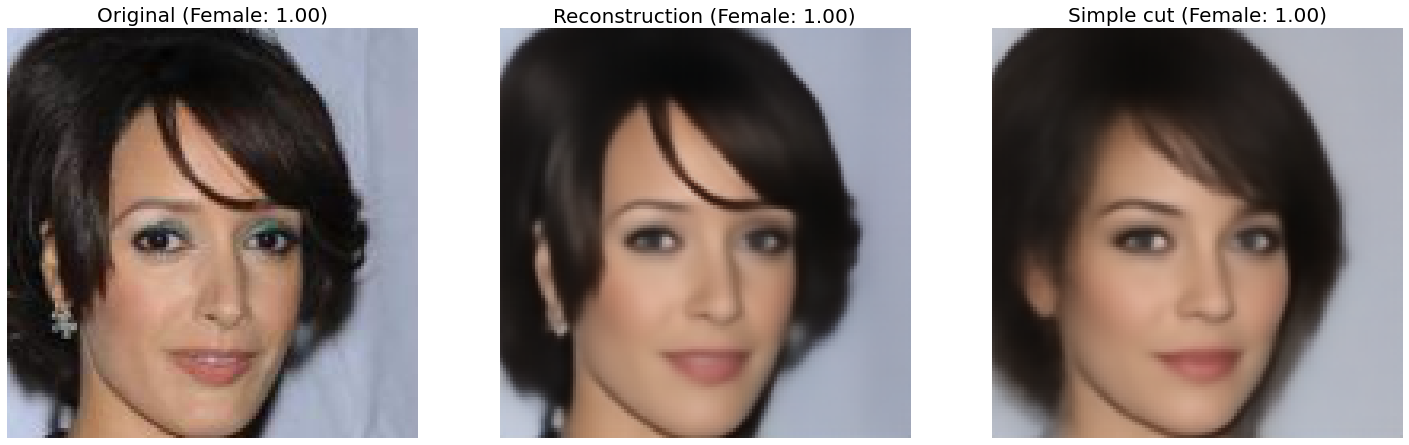

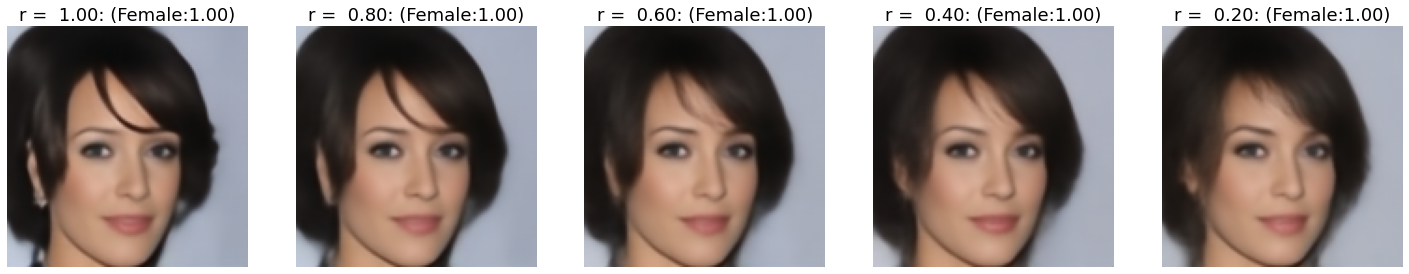

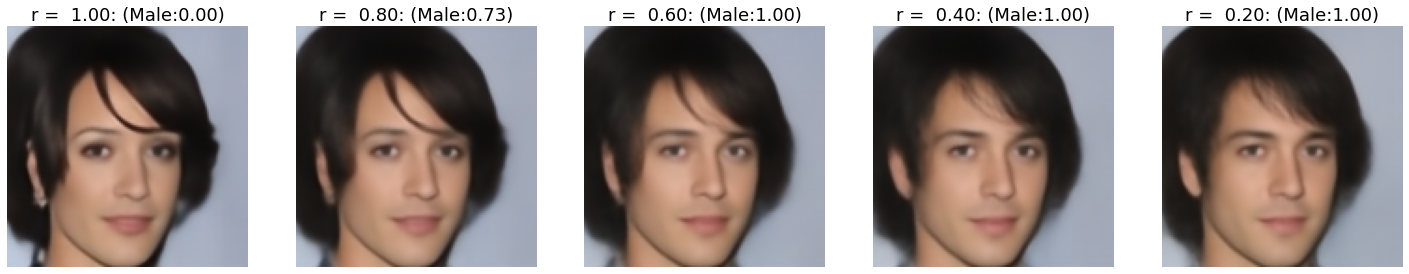

In [ ]:
#@title Visualizing Recon and interpolation from Test Dataset
if not os.path.exists('fig'):
  os.mkdir('fig')
ind =  5#@param {type: "number"}
vae_trainer.visualize_cvae(ind)

  



In [ ]:
#@title VAE loss for samples missclassfied by the classifier
vae_trainer.anomaly_detection(wrong_indices)


torch.int64
Misclassified loss
final_loss: 12984.6953	real_loss: -97274.6953	KLD: 889.2874	NLL: -98163.9844	MSE: 0.0011	ADV: 0.0000	


In [ ]:
#@title Create a random vector (top latent variable)
z_res = (2**(6 - n_resolutions) + 1)**2 #spatial dimention top latent variable
channels = settings['z_dims'][-1] #number of channels
randsamp = torch.randn(1,z_res*(channels-1)) #condition is deterministic

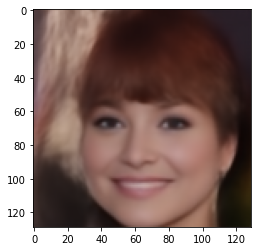

In [ ]:
# @title Generate sample
# Random tensor is fixed
condition_on_input =  1 #@param {type: "number"}
condition_on_z =  5 #@param {type: "number"}
conditioned_input = torch.FloatTensor([[condition_on_input]])
conditioned_z = torch.FloatTensor([z_res*[condition_on_z]])

with torch.no_grad():
    vae.eval()
    if explainability in ['','CPrior','Prior']:
      random_output = vae.decoder(dict(hidden=[]), torch.cat([conditioned_z,randsamp],dim=1).to(device))
    else:
      random_output = vae.decoder(dict(hidden=[]),conditioned_input.to(device),torch.cat([conditioned_z,randsamp],dim=1).to(device))  
random_sample = vae_trainer.show(random_output['recon'][0])
plt.imshow(random_sample)
plt.show
plt.axis('off')